In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import itertools
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

import dql
import utils
import optim
import policies

import gym
from gym import spaces
from gym.utils import seeding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

In [4]:
# current considerations:

# either my implementation
# => self.probabilistic_actions = list(range(2, n_actions  + 2))   # i would like separate actions
#   => action_q_values = q[state].copy()
#   => action_q_values[~legal_actions] = np.nan
#   => action = np.nanargmax(action_q_values)    # this breaks ties deterministically

# or the one that reproduces results from the book (but does not make much sense to me)
# this hill is only due to random tie breaking of the many probabilistic actions from B
# due to the many actions, it takes longer for the Q values to closely approximate their true values
# if (as in my implementation), nanargmax is just (equivilaent but deterministic tie breaking),
# then the q value is learned faster and therefore the curves of q learning and double q learning look 
# a lot more similar, except for the fact that dql converges faster of course

# => self.probabilistic_actions = list(range(n_actions))   # dont like it bc it includes LEFT and RIGHT
# => np.random.choice(np.where(b == b.max())[0])          # this breaks ties randomly

In [5]:
class ToyExampleEnv(gym.Env):
    """ Toy example environment to illustrate the problem of maximization bias """

    metadata = {'render.modes': []}
    
    LEFT = 0
    RIGHT = 1
    
    STATE_A = 0
    STATE_B = 1
    STATE_A_TERMINAL = 2
    STATE_B_TERMINAL = 3
    
    INITIAL_STATE = STATE_A
    TERMINAL_STATES = [STATE_A_TERMINAL, STATE_B_TERMINAL]

    def __init__(self,  mu=-0.1, std=1, n_actions=10):
        super().__init__()
        self.mu = mu
        self.std = std
        
        # self.probabilistic_actions = list(range(2, n_actions  + 2))
        self.probabilistic_actions = list(range(n_actions))
        
        # define actions
        self.actions = [self.LEFT, self.RIGHT] + self.probabilistic_actions
        self.nA = len(self.actions)
        self.action_space = spaces.Discrete(len(self.actions))
        
        # define states
        self.state = self.INITIAL_STATE
        self.states = [self.STATE_A, self.STATE_B, self.STATE_A_TERMINAL, self.STATE_B_TERMINAL]
        self.nS = len(self.states)
        
        # there are no observations
        self.observation_space = spaces.Discrete(len(self.states))
        
        self.state_transitions = {
            self.STATE_A: {
                self.LEFT: self.STATE_B,
                self.RIGHT: self.STATE_A_TERMINAL,
            },
            self.STATE_B: {
                a: self.STATE_B_TERMINAL for a in self.probabilistic_actions
            },
            self.STATE_A_TERMINAL: {
                self.RIGHT: self.STATE_A_TERMINAL, # really does not matter which one
            },
            self.STATE_B_TERMINAL: {
                self.LEFT: self.STATE_B_TERMINAL, # really does not matter which one
            },
        }
        
        self.np_random = None
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return seed
        
    def step(self, action):
        assert self.action_space.contains(action)
        legal_transitions = self.state_transitions.get(self.state, dict())
        reward = 0
        if action in legal_transitions:
            if self.state == self.STATE_B:
                reward = self.np_random.normal(self.mu, self.std)
            self.state = legal_transitions[action]
            
        done = self.state in self.TERMINAL_STATES
        return self.state, reward, done, {}
    
    def legal_actions(self, state):
        legal_transitions = self.state_transitions.get(self.state, dict())
        mask = np.zeros(self.nA, dtype=bool)
        mask[list(legal_transitions.keys())] = True
        return mask
    
    def reset(self):
        self.state = self.INITIAL_STATE
        return self.state

In [16]:
params = dict(
    num_episodes=300,
    repetitions=1_00,
    reduction="mean",
    # hyperparameters
    discount_factor=1.0,
    alpha=0.1,
    epsilon=0.1,
)

env = ToyExampleEnv()

In [17]:
def count_left_action_prob_callback(env, repetition, ep, state, action, result, **kwargs):
    # print(repetition)
    if state[0] == env.STATE_A and action == env.LEFT:
        result[repetition,ep] += 1

In [18]:
left_action_prob_q_learning = np.zeros((params["repetitions"], params["num_episodes"]))
left_action_prob_dbl_q_learning = np.zeros((params["repetitions"], params["num_episodes"]))

ep_lengths_q_learning, ep_returns_q_learning = optim.q_learning(
    env,
    callback=partial(count_left_action_prob_callback, result=left_action_prob_q_learning),
    **params
)
ep_lengths_dbl_q_learning, ep_returns_dbl_q_learning = optim.double_q_learning(
    env,
    callback=partial(count_left_action_prob_callback, result=left_action_prob_dbl_q_learning),
    **params
)
# ep_lengths_dbl_q_learning, ep_returns_dbl_q_learning = optim.double_q_learning(env, **params)

left_action_prob_q_learning = left_action_prob_q_learning.mean(axis=0)
left_action_prob_dbl_q_learning = left_action_prob_dbl_q_learning.mean(axis=0)
# left_action_prob_q_learning
# ).mean(axis=0) # .reshape(params["repetitions"], -1)

100%|██████████| 100/100 [00:11<00:00,  8.40it/s]                                                                                                     


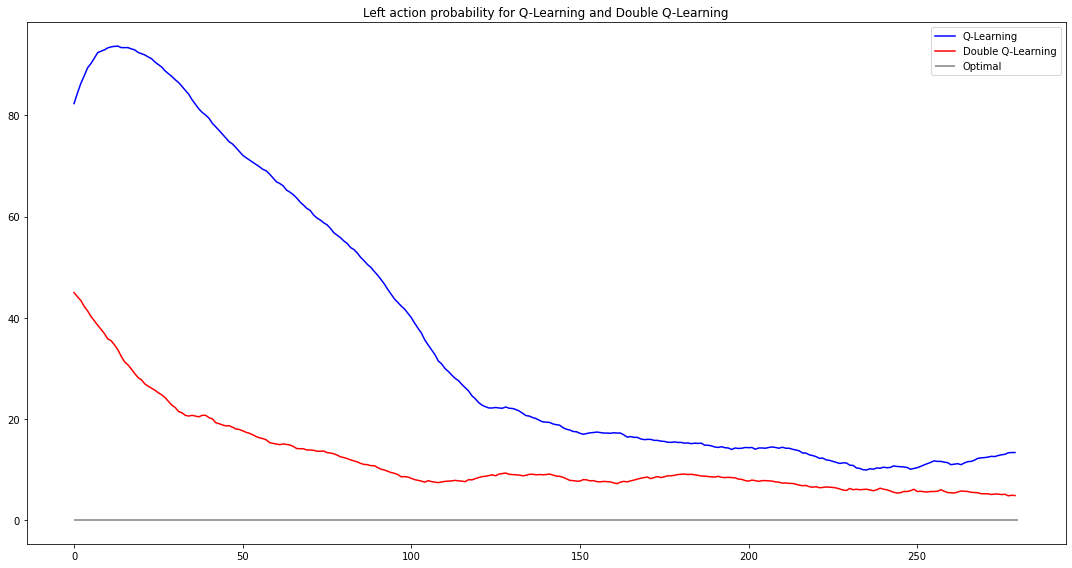

In [19]:
smoothing_radius = 20
plt.figure(figsize=(15,8))
plt.plot(
    utils.smoothing_window(
        left_action_prob_q_learning*100,
        radius=smoothing_radius
    ),
    label='Q-Learning',
    color="blue",
)
plt.plot(
    utils.smoothing_window(
        left_action_prob_dbl_q_learning*100,
        radius=smoothing_radius
    ),
    label='Double Q-Learning',
    color="red",
)
plt.hlines(xmin=0, xmax=params["num_episodes"]-smoothing_radius, y=params["epsilon"]/2, label='Optimal', color="gray")
plt.title('Left action probability for Q-Learning and Double Q-Learning')
plt.legend()
plt.tight_layout()
plt.savefig("../figs/ql_vs_dql_toy_example.pdf")
plt.show()

In [10]:
# todo: remove
mean_left_action_prob_q_learning = []

for repetition in tqdm(
    range(params["repetitions"]),
    bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
):
    Q = np.zeros((env.nS, env.nA))
    policy = policies.EpsilonGreedyPolicy(Q, epsilon=params["epsilon"], reduction=reduction)
    utils.seed(env, policy, seed=42 + repetition)
    
    episode_left_action_prob = np.zeros(params["num_episodes"])
    Q_q_learning, (_, _, ) = dql.q_learning(
        env, policy, Q,
        #num_episodes=num_episodes,
        #discount_factor=discount_factor,
        #alpha=alpha,
        callback=partial(count_left_action_prob_callback, result=episode_left_action_prob),
        **params,
    )
    assert np.max(episode_left_action_prob) <= 1
    assert Q_q_learning[env.TERMINAL_STATES,:].sum() == 0
    mean_left_action_prob_q_learning.append(episode_left_action_prob.copy())
    
mean_left_action_prob_q_learning = np.array(
    mean_left_action_prob_q_learning
).mean(axis=0)

  0%|          | 0/2 [00:00<?, ?it/s]                                                                                                                 


NameError: name 'reduction' is not defined

In [ ]:
# todo: remove
mean_left_action_prob_double_q_learning = []

for repetition in tqdm(
    range(repetitions),
    bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
):
    Q1 = np.zeros((env.nS, env.nA))
    Q2 = np.zeros_like(Q1)
    policy = policies.EpsilonGreedyPolicy(Q1, Q2, epsilon=epsilon, reduction=reduction)
    utils.seed(env, policy, seed=42 + repetition)
    
    episode_left_action_prob = np.zeros(num_episodes)
    Q_double_q_learning, _, _, (
        _, _,
    ) = dql.double_q_learning(
        env, policy, Q1, Q2,
        #num_episodes=num_episodes,
        #discount_factor=discount_factor,
        #alpha=alpha,
        #reduction=reduction,
        callback=partial(count_left_action_prob_callback, result=episode_left_action_prob),
        **params,
    )
    assert np.max(episode_left_action_prob) <= 1
    assert Q_double_q_learning[env.TERMINAL_STATES,:].sum() == 0
    mean_left_action_prob_double_q_learning.append(episode_left_action_prob)

mean_left_action_prob_double_q_learning = np.array(
    mean_left_action_prob_double_q_learning
).mean(axis=0)

In [ ]:
# todo: remove
smoothing_radius = 20
plt.figure(figsize=(15,8))
plt.plot(
    utils.smoothing_window(
        left_action_prob_q_learning*100,
        radius=smoothing_radius
    ),
    label='Q-Learning',
    color="blue",
)
plt.plot(
    utils.smoothing_window(
        left_action_prob_q_learning*100,
        radius=smoothing_radius
    ),
    label='Double Q-Learning',
    color="red",
)
plt.hlines(xmin=0, xmax=params["num_episodes"]-smoothing_radius, y=params["epsilon"]/2, label='Optimal', color="gray")
plt.title('Left action probability for Q-Learning and Double Q-Learning')
plt.legend()
plt.tight_layout()
plt.savefig("../figs/ql_vs_dql_toy_example.pdf")
plt.show()